<a href="https://colab.research.google.com/github/Susanna-Salata/goit-DS/blob/main/GOIT_DS_HomeWork_9_tensorflow_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 1s 0us/step


In [76]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        # Место для вашего кода
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x):
        # Место для вашего кода
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    # Место для вашего кода
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Второй слой, состоящий из 256 нейронов
    # Место для вашего кода
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Выходной слой
    # Место для вашего кода
    self.layer_out = DenseLayer(in_features=n_hidden_2, out_features=num_classes)
    # self.w = tf.Variable(tf.ones([num_features,
    #                               n_hidden_1, 
    #                               n_hidden_2, 
    #                               num_classes]),name='weight')
    # self.b = tf.Variable(tf.zeros([num_classes]),name='bias')

  def __call__(self, x):
    # Место для вашего кода
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_out(x)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов

    return tf.nn.softmax(x)



In [77]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    # tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    # tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    # all = K.int_shape(y_true)[1]
    
    # acc = (tp + tn) / (all + K.epsilon())
    m = tf.metrics.Accuracy()
    m.update_state(y_pred, y_true)
    return m.result().numpy()

In [78]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
    # Место для вашего кода
    trainable_variables = neural_net.trainable_variables

    gradients = g.gradient(loss, trainable_variables)
    # print(gradients)
    # dw, db, _  = gradients

    # Вычислим по ним значение градиента
    # Место для вашего кода
    optimizer.apply_gradients(zip(gradients,trainable_variables))
    
    # Модифицируем параметры
    # Место для вашего кода
    for p in range(len(gradients)):
        trainable_variables[p].assign_sub(learning_rate * gradients[p])
    # nn.w.assign_sub(learning_rate * dw)
    # nn.b.assign_sub(learning_rate * db)

In [90]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps),1):# Место для вашего кода: 

    # Обновляем веса нейронной сети
    # Место для вашего кода
    train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)

        # Место для вашего кода
        loss = cross_entropy(pred, batch_y)
        loss_history += [loss.numpy()]
        batch_y_cl = tf.one_hot(batch_y, depth=num_classes)
        # print(pred)
        # print(batch_y)
        acc = accuracy(pred, batch_y_cl)
        accuracy_history += [acc]
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 4538.395508, accuracy: 0.828125
step: 200, loss: 4289.716309, accuracy: 0.836328
step: 300, loss: 4186.099609, accuracy: 0.840625
step: 400, loss: 4351.886230, accuracy: 0.835156
step: 500, loss: 4455.502441, accuracy: 0.829297
step: 600, loss: 4414.055664, accuracy: 0.832031
step: 700, loss: 4476.225586, accuracy: 0.830078
step: 800, loss: 4331.163086, accuracy: 0.835938
step: 900, loss: 4414.055664, accuracy: 0.831641
step: 1000, loss: 4372.609375, accuracy: 0.833984
step: 1100, loss: 4351.886230, accuracy: 0.835547
step: 1200, loss: 4206.823242, accuracy: 0.839453
step: 1300, loss: 4020.313965, accuracy: 0.846484
step: 1400, loss: 4082.483398, accuracy: 0.844531
step: 1500, loss: 4165.376465, accuracy: 0.842188
step: 1600, loss: 4248.269531, accuracy: 0.837891
step: 1700, loss: 4289.716309, accuracy: 0.836719
step: 1800, loss: 4165.376465, accuracy: 0.840625
step: 1900, loss: 4268.992676, accuracy: 0.837500
step: 2000, loss: 4393.333008, accuracy: 0.832812
step: 210

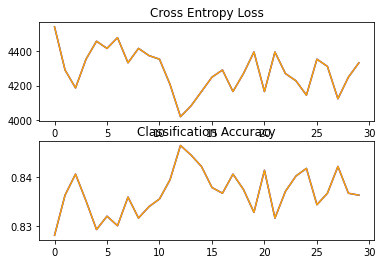

In [91]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

# Место для вашего кода
# plot loss
plt.subplot(2, 1, 1)
plt.title('Cross Entropy Loss')
plt.plot(loss_history, color='blue', label='train')
plt.plot(loss_history, color='orange', label='test')
# plot accuracy
plt.subplot(2, 1, 2)
plt.title('Classification Accuracy')
plt.plot(accuracy_history, color='blue', label='train')
plt.plot(accuracy_history, color='orange', label='test')
plt.show()

In [95]:
# Вычислите точность обученной нейросети

# Место для вашего кода
pred = neural_net(x_test)
print('Test Accuracy:%f'%accuracy(pred, tf.one_hot(y_test, depth=num_classes)))

Test Accuracy:0.837400


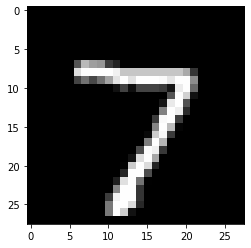

Model prediction:0


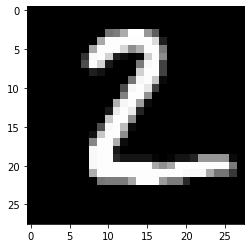

Model prediction:0


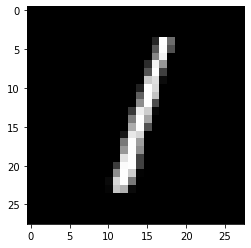

Model prediction:7


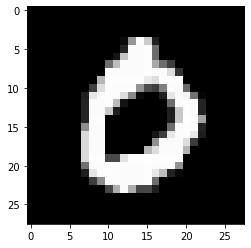

Model prediction:0


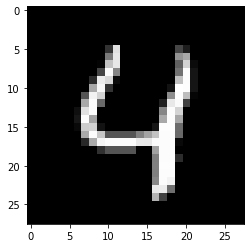

Model prediction:4


In [93]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

# Место для вашего кода
n_images = 5
test_images = x_test[:n_images]
predictions = neural_net(test_images)

# display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i],[28,28]),cmap='gray')
    plt.show()
    print('Model prediction:%i'%np.argmax(predictions.numpy()[i]))